In [1]:
### On top of the Embeddedings gained from Bertweet, I added simple Neural network to 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score



In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
pheme = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

In [5]:
### Data with BERTweet Embedding consists of 797 Dimensions: which are 767 Embeddings and 30 additional features

### Other Dataset consists of 328 dimensions

In [6]:
## Print to Test

In [7]:
print("Shape of the Train and test data of Averaged Word2Vec: {}/{}".format(data.shape, test_data.shape))
# print("Shape of the Train and test data of Doc2vec: {}/{}".format(train_doc.shape, test_doc.shape))
# print("\nShape of the validation data of Avg: {}".format(valid_avg.shape))
# print("Shape of the validation data of Doc2vec: {}".format(valid_doc.shape))
# print("\nShape of the data w/ BERTweet: {}".format(df_bertweet.shape))
# print("\nShape of the validation data w/ BERTweet: {}".format(df_valid_bertweet.shape))

NameError: name 'data' is not defined

In [6]:
# Dropping Target values from the dataset
# train_y = train_avg.isRumor
# test_y = test_avg.isRumor
# valid_y = valid_avg.isRumor
# df_bertweet_y = df_bertweet.isRumor
# df_valid_bertweet_y = df_valid_bertweet.isRumor
# for dataset in [train_avg, test_avg, train_doc, test_doc, valid_avg, valid_doc, df_bertweet, df_valid_bertweet]:
#     dataset.drop(['isRumor'], axis=1, inplace=True)

# print(train.shape, test_y.shape, valid_y.shape, df_bertweet_y.shape, df_valid_bertweet_y.shape)
print(y.shape, test_y.shape)

(5802, 1) (5227, 1)


In [7]:
# # Base dataset are the baseline feature set to be inputted to the model
# # Here, 4 features are dropped for their lack of predictive power

# train_avg_base = train_avg.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# test_avg_base = test_avg.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# valid_avg_base = valid_avg.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# train_doc_base = train_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# test_doc_base = test_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# valid_doc_base = valid_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# bertweet_base = df_bertweet.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# bertweet_valid_base = df_valid_bertweet.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)

In [ ]:
# Torch

In [ ]:
## BERTCLF 노트북을 참고한 방법 - Train

In [8]:
train_inputs = torch.tensor(pheme.values).float()
val_inputs = torch.tensor(ext.values).float()

# Convert other data types to torch.Tensor
train_labels = torch.tensor(pheme_y.values).float()
val_labels = torch.tensor(ext_y.values).float()

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [9]:
print("Length of the Inputs are:\nTrain\t%s\nVal\t%s" %(train_inputs.size(), val_inputs.size()))

Length of the Inputs are:
Train	torch.Size([5802, 200])
Val	torch.Size([485, 200])


In [10]:
import random

class AvgW2VNet(torch.nn.Module):
  def __init__(self, freeze_model=False):
    """
    In the constructor we construct three nn.Linear instances that we will use
    in the forward pass.
    """
    super(AvgW2VNet, self).__init__()

    D_in, H, D_out = 200, 16, 1

    self.classifier = nn.Sequential(
        nn.Linear(D_in, H),
        nn.BatchNorm1d(H),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(H, D_out),
        nn.Sigmoid()
    )

    # if freeze_bert:
    #     for param in self.bert.parameters():
    #         param.requires_grad = False

  def forward(self, input):
    result = self.classifier(input)
    return result

In [11]:
# from torch.nn.optim import Adam

def initialize_model(epochs=300):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    model = AvgW2VNet()

    # Tell PyTorch to run the model on GPU
    model.to(device)

    # Create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.1)

    criterion = nn.BCELoss()
    # loss = nn.CrossEntropyLoss()

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    # scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                             num_warmup_steps=0, # Default value
    #                                             num_training_steps=total_steps)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=0.1, gamma= 0.99)       

    return model, optimizer, criterion, scheduler
    # return bert_classifier, optimizer, scheduler


In [12]:
import time

In [13]:
set_seed(42)    # Set seed for reproducibility
model, optimizer, criterion, scheduler = initialize_model(epochs=100)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()


NameError: name 'set_seed' is not defined

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.639528   |  0.610964  |   25.60   |   0.53   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.647421   |  0.771703  |   25.60   |   0.48   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.647474   |  0.784059  |   25.60   |   0.48   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------

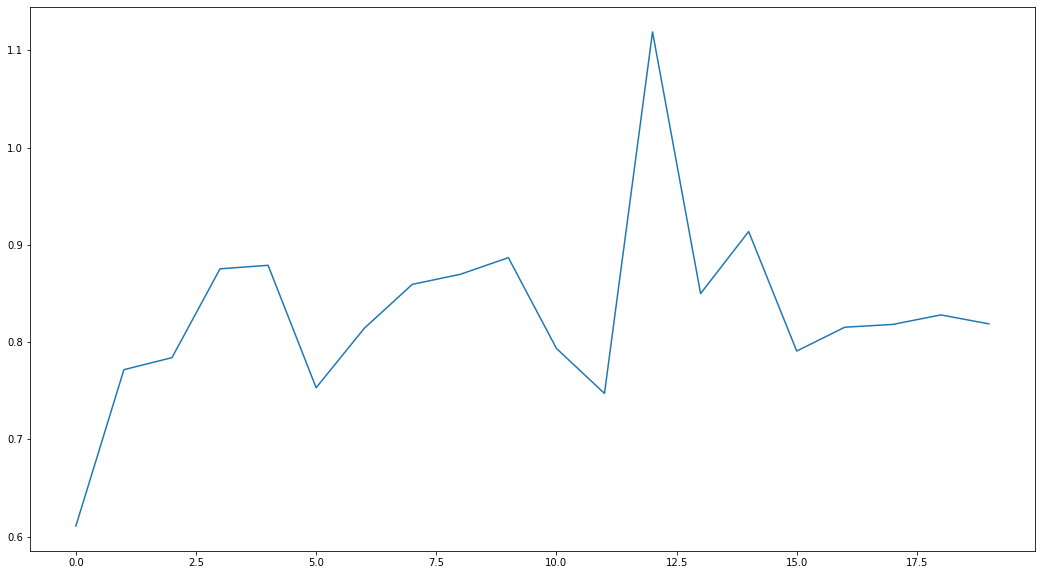

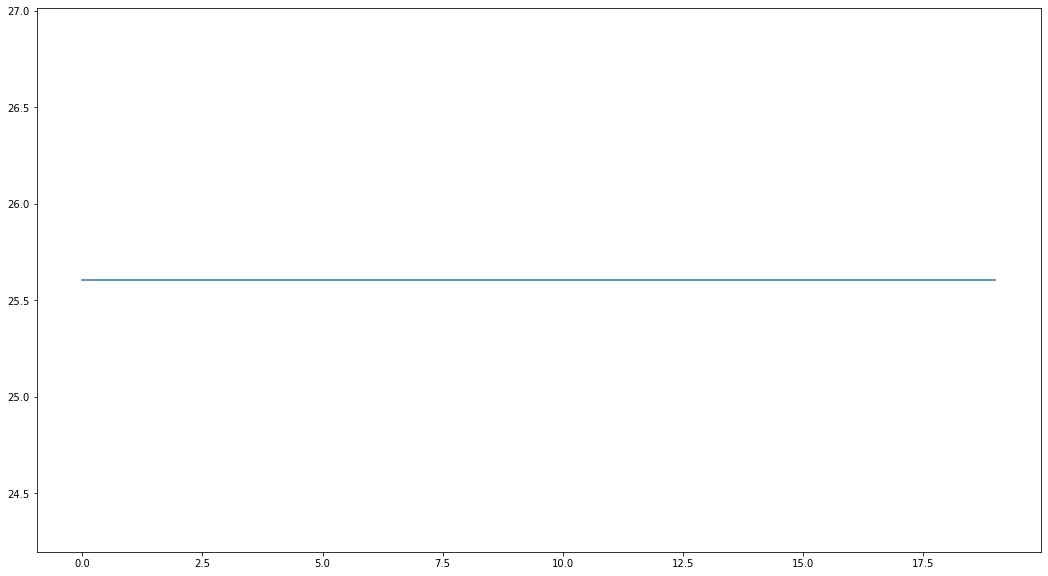

In [356]:
train(model, train_dataloader, val_dataloader, epochs=20, evaluation=True)

In [ ]:
torch.save(model.state_dict(), './MLP_W2V_to_Sigmoid_ord.pt')

In [ ]:
## Test

In [ ]:
PATH = './MLP_W2V_to_Sigmoid_ord.pt'
# bn_state_dict = torch.load('./BERT_raw_to_fine_tune_ord.pt')
# bert_classifier.load_state_dict(bn_state_dict)
model.load_state_dict(torch.load(PATH))

In [370]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [388]:
import torch.nn.functional as F

def model_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input,b_labels = tuple(t.to(device) for t in batch)
        # print(b_input)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu()

    return probs

In [425]:
# Compute predicted probabilities on the test set
probs = model_predict(model, val_dataloader)
probs = probs.numpy()
# print(probs)
# print(type(probs))

# # Evaluate the Bert classifier
# print(len(probs))
target = torch.tensor(ext_y)
target = target.unsqueeze(dim=1).numpy()
# print(target)
# evaluate_roc(probs, target)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

In [ ]:
## adf

In [ ]:
task1_model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task1_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

In [39]:
print(task1_model.parameters)

<bound method Module.parameters of FC_net(
  (fc1): Linear(in_features=792, out_features=130, bias=True)
  (fc2): Linear(in_features=130, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
  (drop_2): Dropout(p=0.2, inplace=False)
)>


In [40]:
import torch.optim as optim

criterion = nn.BCELoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(task1_model.parameters(), lr=0.01)

In [41]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_BERT_fc.pt"
best_acc = 10.0
num_epochs = 10

val_corrects_list = []
val_loss_list = []

In [42]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0
    task1_model.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs, labels = inputs.float(), labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = task1_model(inputs)

        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()    

        running_loss += loss.item()
        running_corrects += torch.sum(outputs == labels.data)
        # print(running_corrects)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print('Train) Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # if epoch_loss < best_acc:
    #     # print("prev_loss: {:.5f}".format(prev_loss))
    #     # print("loss: {:.5f}".format(loss))
    #     print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
    #     torch.save(task1_model.state_dict(),PATH)
    #     best_acc = epoch_loss

Epoch 0/9
----------
Train) Loss: 0.3190 Acc: 0.0042
Epoch 1/9
----------
Train) Loss: 5.4705 Acc: 0.6325
Epoch 2/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 3/9
----------
Train) Loss: 5.7213 Acc: 0.6568
Epoch 4/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 5/9
----------
Train) Loss: 5.7213 Acc: 0.6568
Epoch 6/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 7/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 8/9
----------
Train) Loss: 5.7213 Acc: 0.6568
Epoch 9/9
----------
Train) Loss: 5.7213 Acc: 0.6568


In [43]:
task1_model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task1_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

Accuracy of the test dataset is: 68 %
Loss of validation set: 5.20883


In [1]:
# W2V to MLP

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [15]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [16]:
pheme = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

In [17]:
train_inputs = torch.tensor(pheme.values).float()
val_inputs = torch.tensor(ext.values).float()

# Convert other data types to torch.Tensor
train_labels = torch.tensor(pheme_y.values).float()
val_labels = torch.tensor(ext_y.values).float()

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

print("Length of the Inputs are:\nTrain\t%s\nVal\t%s" %(train_inputs.size(), val_inputs.size()))

Length of the Inputs are:
Train	torch.Size([5802, 200])
Val	torch.Size([485, 200])


In [18]:
class AvgW2VNet(torch.nn.Module):
  def __init__(self, freeze_model=False):
    """
    In the constructor we construct three nn.Linear instances that we will use
    in the forward pass.
    """
    super(AvgW2VNet, self).__init__()

    D_in, H, D_out = 200, 16, 1

    self.classifier = nn.Sequential(
        nn.Linear(D_in, H),
        nn.BatchNorm1d(H),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(H, D_out),
        nn.Sigmoid()
    )

    # if freeze_bert:
    #     for param in self.bert.parameters():
    #         param.requires_grad = False

  def forward(self, input):
    result = self.classifier(input)
    return result

def initialize_model(epochs=300):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    model = AvgW2VNet()

    # Tell PyTorch to run the model on GPU
    model.to(device)

    # Create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.1)

    criterion = nn.BCELoss()
    # loss = nn.CrossEntropyLoss()

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    # scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                             num_warmup_steps=0, # Default value
    #                                             num_training_steps=total_steps)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=0.1, gamma= 0.99)       

    return model, optimizer, criterion, scheduler
    # return bert_classifier, optimizer, scheduler

In [28]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    val_loss_list = []
    val_acc_list = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        # print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input)

            # Compute loss and accumulate the loss values
            # torch.argmax(logits(i)) for logit, i in enumerate(logits)
            
            logits = logits.flatten()
            loss = criterion(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                # print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_accuracy)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            # print(val_loss_list)
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    fig = plt.figure(figsize=(18,10))
    plt.plot(np.arange(0,epochs),val_loss_list)
    fig2 = plt.figure(figsize=(18,10))
    plt.plot(np.arange(0,epochs),val_acc_list)
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input)
            # logits = logits.flatten()

        # Compute loss
        loss = criterion(logits.flatten(), b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        # print(logits.flatten())
        preds = logits >= 0.5
        # print(preds.flatten())

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def model_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input,b_labels = tuple(t.to(device) for t in batch)
        # print(b_input)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu()

    return probs

def testing_process(bert_classifier, X_val, y_val):
    #  Run `preprocessing_for_bert` on the test set
    print('Tokenizing data...')
    test_inputs, test_masks = preprocessing_for_bert(X_val)

    # Create the DataLoader for our test set
    test_dataset = TensorDataset(test_inputs)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)

    # Get predictions from the probabilities
    threshold = 0.5
    preds = np.where(probs[:, 1] > threshold, 1, 0)

    # Number of tweets predicted non-negative
    print("Number of tweets predicted as Rumor: ", preds.sum())

    preds = np.argmax(probs, axis = 1)
    print('Accuracy Score:\t',accuracy_score(y_val, preds))
    print('Precision Score:\t', str(precision_score(y_val,preds)))
    print('Recall Score:\t\t' + str(recall_score(y_val,preds)))
    print('F1 Score:\t',f1_score(y_val, preds, zero_division=1))

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.625833   |  0.818905  |   27.93   |   0.24   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.630503   |  0.726403  |   27.93   |   0.20   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.637972   |  0.785952  |   27.93   |   0.30   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------

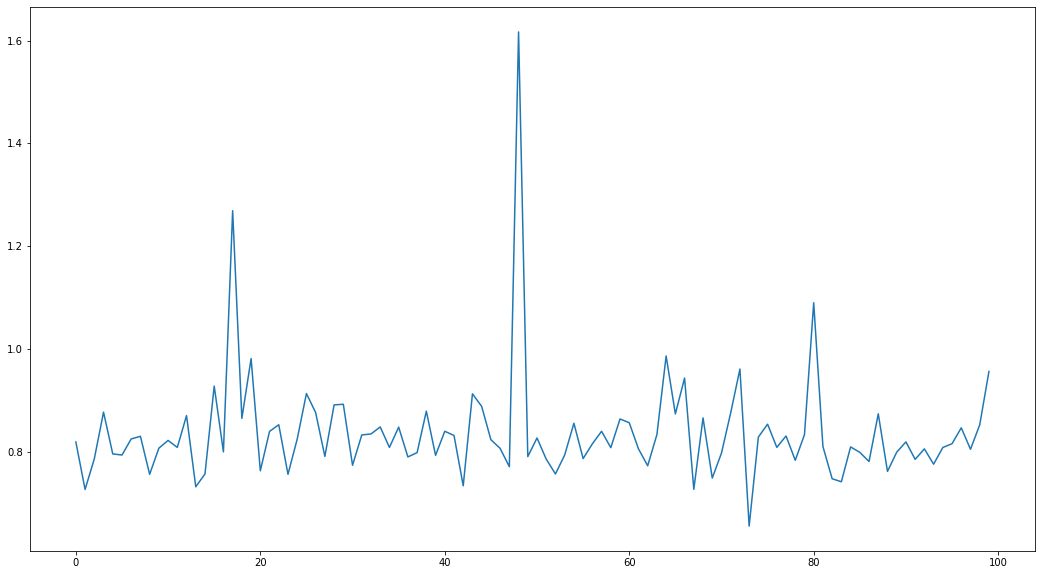

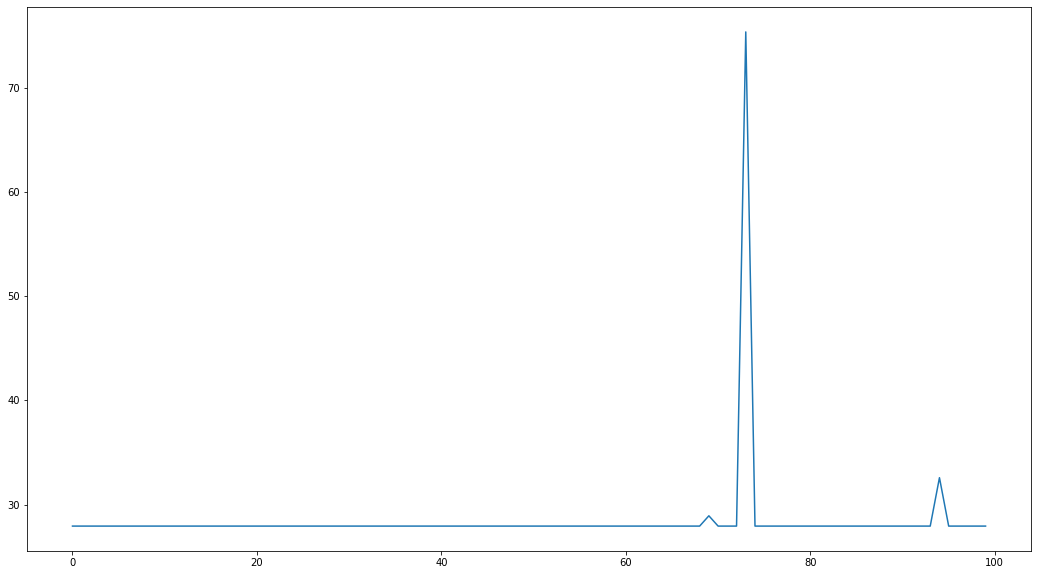

In [29]:
set_seed(42)    # Set seed for reproducibility
model, optimizer, criterion, scheduler = initialize_model(epochs=100)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
train(model, train_dataloader, val_dataloader, epochs=100, evaluation=True)

In [ ]:
torch.save(model.state_dict(), './Model/MLP_W2V_to_Sigmoid_ord.pt')

In [ ]:
PATH = './Model/MLP_W2V_to_Sigmoid_ord.pt'
model.load_state_dict(torch.load(PATH))
testing_process(model, X_val, y_val)

In [ ]:
# Compute predicted probabilities on the test set
probs = model_predict(model, val_dataloader)
probs = probs.numpy()

# # Evaluate the Bert classifier
target = torch.tensor(ext_y)
target = target.unsqueeze(dim=1).numpy()
evaluate_roc(probs, target)

In [ ]:
task1_model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task1_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

In [ ]:
# Using the BERT 최종 > MLP

In [ ]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, f1_score

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import time

import torch
import torch.nn as nn

import random
import time

from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler